# Pet Tornado *(OK, more like a waterspout)*

v1.3 28 May 2018, by Brian Fiedler, with Brian Mapes and David Nolan updates 2/20/2019

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\B}[1]{\overline{#1}}$ 
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\dd}[2]{\frac{\D#1}{\D#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$
$\newcommand{\VI}[1]{\left\langle#1\right\rangle}$
$\require{color}$

### Sections
#### Code cells have to be up top (ugly), so here are jump links to the good stuff 
1. <a href="#Initialize">Choose parameters of experiment (grid and initial buoyant bubble)</a>
1. <a href="#Initialstate">Initialize state and show the initial conditions</a>
1. <a href="#Energy_stats_arrays">Energy stats (ke, pe, te) by timestep</a>
1. <a href="#Stepforward">Step forward in time, plotting the state at intervals</a>
1. <a href="#Animation_and_stats">Crude animation from .png frames, then plot energy statistic time series</a>
1. <a href="#Student_tasks">Student assignment tasks</a>

A cubic domain, a box,  with a buoyant blob is rotating (slowly) about it's central axis.  The blob rises and creates
relative vorticity below.  The stretching and amplification of the vorticity bears some resemblance to the formation of tornadoes within mesoscylones.

The model equations look like they have a coriolis parameter in them, because the domain is rotating (and embedded within) the mesocyclone. Use your imagination.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display,clear_output, Image
import time as Time
import math, os, glob
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request

In [2]:
# Set some notebook style parameters
#HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

We prognosticate the following dimensionless equations:

$$
\pdt{u} + u \pd{u}{x} + v \pd{u}{y} + w \pd{u}{z}= - \pd{P}{x} + \frac{f}{N} v
$$

$$
\pdt{v}{t} + u \pd{v}{x} + v \pd{v}{y} + w \pd{v}{z}=  - \pd{P}{y} - \frac{f}{N} u
$$

$$
\pdt{w} + u \pd{w}{x} + v \pd{w}{y} + w \pd{w}{z}= - \pd{P}{z} + b 
$$

$$
\pd{u}{x} + \pd{v}{y} + \pd{w}{z}  = 0
$$

$$
\pdt{b} + u \pd{b}{x} + v \pd{b}{y} + w \pd{b}{z}= - w 
$$

The non-dimensionalization should be familiar to you. Note the time scale is $1/N$, not seconds.
In the code below, we use `fcoriolis`=$f/N$  

In [3]:
################
def ab_blend(dqdt,order):
# blends the time derivatives for the 1st, 2nd and 3rd order Adams-Bashforth schemes
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")


## Some functions for the 3-D C-grid

In [4]:
##############################################    
def make3dgrid(ix,iy,iz,xmax,ymax,zmax):
# input number of desired gridpoints, and the span of the grid,
# return 3-D arrays of the x y and z coordinates at the grid points
    dx=xmax/(ix-1.)
    dy=ymax/(iy-1.)
    dz=zmax/(iz-1.)
    x1=np.linspace(0,xmax,ix)
    y1=np.linspace(0,ymax,iy)
    z1=np.linspace(0,zmax,iz)
    x=np.zeros( (iz,iy,ix) )
    y=np.zeros( (iz,iy,ix) )
    z=np.zeros( (iz,iy,ix) )
    for j in range(iy):
        for k in range(iz):
            x[k,j,:]=x1
    for i in range(ix):
        for k in range(iz):
            y[k,:,i]=y1
    for i in range(ix):
        for j in range(iy):
            z[:,j,i]=z1
    return x,y,z,dx,dy,dz

##############################################    
def advect_3d(q,u,v,w,dx,dy,dz):
# 3rd-order upwind advection
    dqdt=np.zeros(q.shape)
    dqmx=np.zeros(q.shape)
    dqpx=np.zeros(q.shape)
    dqmy=np.zeros(q.shape)
    dqpy=np.zeros(q.shape)
    dqmz=np.zeros(q.shape)
    dqpz=np.zeros(q.shape)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    dqmx[:,:,1]  = q[:,:,1]-q[:,:,0]  #1
    dqmx[:,:,2:-1] = (2*q[:,:,3:]+3*q[:,:,2:-1]-6*q[:,:,1:-2]+q[:,:,:-3])/6. #3
    dqpx[:,:,-2] = q[:,:,-1]-q[:,:,-2] #1
    dqpx[:,:,1:-2] = -(2*q[:,:,0:-3]+3*q[:,:,1:-2]-6*q[:,:,2:-1]+q[:,:,3:])/6. #3

    dqmy[:,1,:]  = q[:,1,:]-q[:,0,:] #1
    dqmy[:,2:-1,:] =  (2*q[:,3:,:]+3*q[:,2:-1,:]-6*q[:,1:-2,:]+q[:,:-3,:])/6. #3
    dqpy[:,-2,:] = q[:,-1,:]-q[:,-2,:] #1
    dqpy[:,1:-2,:] = -(2*q[:,0:-3,:]+3*q[:,1:-2,:]-6*q[:,2:-1,:]+q[:,3:,:])/6. #3

    dqmz[1,:,:]  = q[1,:,:]-q[0,:,:]  #1
    dqmz[2:-1,:,:] = (2*q[3:,:,:]+3*q[2:-1,:,:]-6*q[1:-2,:,:]+q[:-3,:,:])/6. #3
    dqpz[-2,:,:] = q[-1,:,:]-q[-2,:,:] #1
    dqpz[1:-2,:,:] = -(2*q[0:-3,:,:]+3*q[1:-2,:,:]-6*q[2:-1,:,:]+q[3:,:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy
    dqdz=np.where(w>0.,dqmz,dqpz)/dz

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    dqdt+=-w*dqdz
    return dqdt


In [5]:
############################################## 
# periodic version
def advect_3dp(q,u,v,w,dx,dy,dz,per='U'): 
# 3rd-order upwind advection
    sh = q.shape
    Q = np.zeros( (sh[0],sh[1]+4,sh[2]+4) )
    Q[:, 2:-2 , 2:-2] = q
    
    if per=='U':        
        Q[ : , :2 , 2:-2 ] = q[ : , -3:-1 , : ]
        Q[ : , -2: , 2:-2] = q[ : , 1:3 , : ]
        Q[ : , 2:-2 , :2] = q[ : , : , -3:-1 ]
        Q[ : , 2:-2 , -2:] = q[ : , : , 1:3 ]
    elif per=='u':
        Q[ : , :2 , 2:-2 ]  = q[ : , -2: , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , :2  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -3:-1 ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , 1:3 ]
    elif per=='v':
        Q[ : , :2 , 2:-2 ]  = q[ : , -3:-1 , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , 1:3  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -2: ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , :2 ] 
    elif per=='w':
        Q[ : , :2 , 2:-2 ]  = q[ : , -2: , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , :2  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -2: ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , :2 ] 
        
    
    dqdt=np.zeros(sh)
    dqmx=np.zeros(sh)
    dqpx=np.zeros(sh)
    dqmy=np.zeros(sh)
    dqpy=np.zeros(sh)
    dqmz=np.zeros(sh)
    dqpz=np.zeros(sh)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    
    dqmx[:,:,:] =  (2*Q[:,2:-2,3:-1] + 3*Q[:,2:-2,2:-2] - 6*Q[:,2:-2,1:-3] + Q[:,2:-2,:-4])/6. 
    dqpx[:,:,:] = -(2*Q[:,2:-2,1:-3] + 3*Q[:,2:-2,2:-2] - 6*Q[:,2:-2,3:-1] + Q[:,2:-2,4:] )/6.
    
    dqmy[:,:,:] =  (2*Q[:,3:-1,2:-2] + 3*Q[:,2:-2,2:-2] - 6*Q[:,1:-3,2:-2] + Q[:,:-4,2:-2])/6. 
    dqpy[:,:,:] = -(2*Q[:,1:-3,2:-2] + 3*Q[:,2:-2,2:-2] - 6*Q[:,3:-1,2:-2] + Q[:,4:,2:-2] )/6. 

    dqmz[1,:,:]  = q[1,:,:]-q[0,:,:]  #1
    dqmz[2:-1,:,:] = (2*q[3:,:,:]+3*q[2:-1,:,:]-6*q[1:-2,:,:]+q[:-3,:,:])/6. #3
    dqpz[-2,:,:] = q[-1,:,:]-q[-2,:,:] #1
    dqpz[1:-2,:,:] = -(2*q[0:-3,:,:]+3*q[1:-2,:,:]-6*q[2:-1,:,:]+q[3:,:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy
    dqdz=np.where(w>0.,dqmz,dqpz)/dz

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    dqdt+=-w*dqdz
    return dqdt


In [6]:
# divergence on the C-grid
def div_Cgrid(u,v,w,dx,dy,dz):
    return (u[:,:,1:]-u[:,:,:-1])/dx + (v[:,1:,:]-v[:,:-1,:])/dy + (w[1:,:,:]-w[:-1,:,:])/dz

In [7]:
def pgf_3dp(p,dx,dy,dz):
# 20 May 2016 Periodic
# Calculates periodic pressure gradient force on the U-grid

    dudt=np.zeros( (p.shape[0]+1, p.shape[1]+1 , p.shape[2]+1 ) )
    dvdt=np.zeros( dudt.shape )
    dwdt=np.zeros( dudt.shape )
    
    P = np.zeros( (p.shape[0], p.shape[1]+2 , p.shape[2]+2 ) )
    P[:,1:-1,1:-1] = p
    P[:,0,1:-1] = p[:,-1,:]
    P[:,-1,1:-1] = p[:,0,:]
    P[:,1:-1,0] = p[:,:,-1]
    P[:,1:-1,-1] = p[:,:,0]
    
    dpx = (P[:,:,1:]-P[:,:,:-1])/dx 
    dudt[ 1:-1 , : , : ] = -.25* ( dpx[:-1,:-1,:] + dpx[:-1,1:,:]  
                                  +dpx[1:,:-1,:]  + dpx[1:,1:,:] )    
    dudt[ 0, : , :]  =  -.5*(dpx[0,1:,:] + dpx[0,:-1,:] ) 
    dudt[-1 ,: , :] =  -.5*(dpx[-1,1:,:] + dpx[-1,:-1,:] ) 
    
    dpy =  (P[:,1:,:]-P[:,:-1,:])/dy 
    dvdt[1:-1,:,:] = -.25* ( dpy[:-1,:,:-1] + dpy[:-1,:,1:] 
                                  +dpy[1:,:,:-1] + dpy[1:,:,1:] ) 
    dvdt[0, : , :] = -.5* ( dpy[0,:,1:] + dpy[0,:,:-1] ) 
    dvdt[-1,: , :] = -.5* ( dpy[-1,:,1:] + dpy[-1,:,:-1] ) 
   
    dpz =  (P[1:,:,:]-P[:-1,:,:])/dz 
    dwdt[1:-1, :, :] = -.25* ( dpz[:,:-1,:-1] + dpz[:,:-1,1:] 
                              +dpz[:,1:,:-1] + dpz[:,1:,1:] ) 
    
    return dudt,dvdt,dwdt


In [8]:
############
#Interpolators for the C grid
def v_to_u(v,bnd='slip'):
    iz,iy,ix = v.shape
    atu=np.zeros((iz,iy-1,ix+1))
    atu[:,:,1:-1] = .25*( v[:,:-1,:-1] + v[:,:-1,1:] + v[:,1:,:-1] + v[:,1:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( v[:,:-1,-1] + v[:,:-1,0] + v[:,1:,-1] + v[:,1:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu
def w_to_u(w,bnd='slip'):
    iz,iy,ix = w.shape
    atu=np.zeros((iz-1,iy,ix+1))
    atu[:,:,1:-1] = .25*( w[:-1,:,:-1] + w[:-1,:,1:] + w[1:,:,:-1] + w[1:,:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( w[:-1,:,-1] + w[:-1,:,0] + w[1:,:,-1] + w[1:,:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu
def u_to_v(u,bnd='slip'):
    iz,iy,ix = u.shape
    atv=np.zeros((iz,iy+1,ix-1))
    atv[:,1:-1,:] = .25*( u[:,:-1,:-1] + u[:,:-1,1:] + u[:,1:,:-1] + u[:,1:,1:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( u[:,-1,:-1] + u[:,-1,1:] + u[:,0,:-1] + u[:,0,1:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv
def w_to_v(w,bnd='slip'):
    iz,iy,ix = w.shape
    atv=np.zeros((iz-1,iy+1,ix))
    atv[:,1:-1,:] = .25*( w[:-1,:-1,:] + w[:-1,1:,:] + w[1:,:-1,:] + w[1:,1:,:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( w[:-1,-1,:] + w[:-1,0,:] + w[1:,-1,:] + w[1:,0,:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv

def u_to_w(u,bnd='slip'):
    iz,iy,ix = u.shape
    atw=np.zeros((iz+1,iy,ix-1))
    atw[1:-1,:,:] = .25*( u[:-1,:,:-1] + u[:-1,:,1:] + u[1:,:,:-1] + u[1:,:,1:] )
    if bnd=='slip':
        atw[0,:,:] = atw[1,:,:]
        atw[-1,:,:] = atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw
def v_to_w(v,bnd='slip'):
    iz,iy,ix = v.shape
    atw=np.zeros((iz+1,iy-1,ix))
    atw[1:-1,:,:] = .25*( v[:-1,:-1,:] + v[:-1,1:,:] + v[1:,:-1,:] + v[1:,1:,:] )
    if bnd=='slip':
        atw[0,:,:]=atw[1,:,:]
        atw[-1,:,:]=atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw

# These are easy for the C-grid.
def u_to_p(u):
    return (u[:,:,:-1] + u[:,:,1:] )*.5
def v_to_p(v):
    return (v[:,:-1,:] + v[:,1:,:] )*.5        
def w_to_p(w):
    return (w[:-1,:,:] + w[1:,:,:] )*.5   

#############################################################
def U2p_3d(U):
# interpolates U-grid array to a p-grid array
    return .125*( U[1:,:-1,1:]  + U[1:,1:,1:]  + U[1:,:-1,:-1]  + U[1:,1:,:-1]
                + U[:-1,:-1,1:] + U[:-1,1:,1:] + U[:-1,:-1,:-1] + U[:-1,1:,:-1])

In [9]:
#######################3
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

# non-hydrostatic pressure solver

In [10]:
def lapl_p_3d(p,dx,dy,dz):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2 + d^2/dz^2,
# assumimg no normal pressure gradient at boundaries.
# Uses image points outside of the domain of p, so the returned laplacian
# is the same size as p
    sh=p.shape
    b = np.zeros((sh[0]+2,sh[1]+2,sh[2]+2)) # make bigger array
    # stuff in image point values:
    b[1:-1,1:-1,1:-1]=p
    b[1:-1,1:-1,0]=p[:,:,0]
    b[1:-1,1:-1,-1]=p[:,:,-1]
    b[1:-1,0,1:-1]=p[:,0,:]
    b[1:-1,-1,1:-1]=p[:,-1,:]
    b[0,1:-1,1:-1]=p[0,:,:]
    b[-1,1:-1,1:-1]=p[-1,:,:]
    dx2=dx*dx
    dy2=dy*dy
    dz2=dz*dz
    laplp=np.zeros(sh)
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,1:-1,:-2] + b[1:-1,1:-1,2:])/dx2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,2:,1:-1] + b[1:-1,:-2,1:-1])/dy2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[2:,1:-1,1:-1] + b[:-2,1:-1,1:-1])/dz2
    return laplp

def lapl_p_3d_periodic(p,dx,dy,dz):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2 + d^2/dz^2,
# assumimg x and y are periodic, and no normal pressure gradient at top and bottom
# Uses image points outside of the domain of p, so the returned Laplacian
# is the same size as p
    sh=p.shape
    b = np.zeros((sh[0]+2,sh[1]+2,sh[2]+2)) # make bigger array
    # stuff in image point values:
    b[1:-1,1:-1,1:-1]=p
    b[1:-1,1:-1,0]=p[:,:,-1]
    b[1:-1,1:-1,-1]=p[:,:,0]
    b[1:-1,0,1:-1]=p[:,-1,:]
    b[1:-1,-1,1:-1]=p[:,0,:]
    b[0,1:-1,1:-1]=p[0,:,:]
    b[-1,1:-1,1:-1]=p[-1,:,:]
    dx2=dx*dx
    dy2=dy*dy
    dz2=dz*dz
    laplp = np.zeros(sh)
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,1:-1,:-2] + b[1:-1,1:-1,2:])/dx2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,2:,1:-1] + b[1:-1,:-2,1:-1])/dy2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[2:,1:-1,1:-1] + b[:-2,1:-1,1:-1])/dz2
    return laplp

def poisson3d_p_fft_prep(sh,dx,dy,dz,lapl='discrete',periodic=False):
    
    # You must run this and save the array output for input into poisson_cosine_3.
    # poisson_cosine_3 is for box domains with boundary conditions of no normal
    # pressure gradient. As such, the pressure can be represented by a 3-D Fourier
    # cosine series.
        
    L = dx*sh[2] 
    W = dy*sh[1]
    H = dz*sh[0]
    
    Ka = np.arange(sh[2]) # the wavenumbers of the cos functions in the x-direction
    Ma = np.arange(sh[1]) # ... in the y-direction
    Na = np.arange(sh[0]) # ... in the z-direction  
    
    if periodic: # use both sine and cosine
        Ka[1::2] += 1 
        Ma[1::2] += 1
      
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W
    na = Na*np.pi/H

    # Suppose we have an amplitude of a certain Fourier mode of del2p.
    # (Usually del2p is the divergence of acceleration prior to adding the PGF.)
    # We want to find a mode of p such that the finite-difference form of 
    # Laplacian operator operating on p give this amplitude. 
    # The reciprocal of the lapl_op multipled by the amplitude of the Fourier
    # mode of del2p will give the amplitude of this Fourier mode of p.
    # Note: the continuous form, as opposed to discrete form, of lapl_op is very simple.
    # You are welcome to uncomment it and experiment with it.
    
    lapl_op = np.zeros(sh)
    if lapl == 'discrete':
        lapl_op[:] = (2*np.cos(ka*dx)-2)/dx**2
        more =  (2*np.cos(ma*dy)-2)/dy**2
        lapl_op += more.reshape(1,sh[1],1)
        more =  (2*np.cos(na*dz)-2)/dz**2
        lapl_op += more.reshape(sh[0],1,1)
    else: # use simple, calculus form for d^2/dx^2, etc.
        lapl_op[:] = -ka**2
        more = -ma**2 
        lapl_op += more.reshape(1,sh[1],1)    
        more = -na**2
        lapl_op += more.reshape(sh[0],1,1)
    
    lapl_op[0,0,0]=1. # Prevents division by zero. (The [0,0,0] Fourier mode is zero anyways)
    
    return 1./lapl_op # the inverse Laplacian operator

def poisson3d_p_fft(del2p,inv_lapl_op,periodic=False):
    
    # 3-D pressure solver
    # del2p is the desired Laplacian of pressure.
    # inv_lapl_op is from poisson_cosine_3_prep
    # pressure is assumed to have no normal pressure gradient at boundaries.
    # Assumes a C-grid.  The physical boundary is half a grid cell away from 
    # the pressure points. Thus type=2. 
    # dct means discrete cosine transform.
    # p has the same shape as d2p.  Fastest shape (64,64,64), (128,128,128), etc
    
    if not periodic:
        sh = del2p.shape
        del2pt = scipy.fftpack.dct( del2p , axis=2, type=2) 
        del2pt = scipy.fftpack.dct( del2pt , axis=1, type=2)
        del2pt = scipy.fftpack.dct( del2pt , axis=0, type=2)
        # del2pt is now the amplitudes of the Fourier modes of del2p

        pt = del2pt*inv_lapl_op # amplitudes of Fourier modes of pressure

        pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
        pt = scipy.fftpack.idct(pt,axis=1,type=2) # inverse transform of pt to p
        p = scipy.fftpack.idct(pt,axis=2,type=2) # inverse transform of pt to p
        p = p/(8*sh[0]*sh[1]*sh[2]) #The need for this division is convention of fft
        p -= p.mean() 

    else:
        sh = del2p.shape
        del2pt = scipy.fftpack.rfft( del2p , axis=2) 
        del2pt = scipy.fftpack.rfft( del2pt , axis=1)
        del2pt = scipy.fftpack.dct( del2pt , axis=0, type=2)
        # del2pt is now the amplitudes of the Fourier modes of del2p

        pt = del2pt*inv_lapl_op # amplitudes of Fourier modes of pressure

        pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
        pt = scipy.fftpack.irfft(pt,axis=1) # inverse transform of pt to p
        p = scipy.fftpack.irfft(pt,axis=2) # inverse transform of pt to p
        p = p/(2*sh[0]) #The need for this division is convention of fft
        p -= p.mean() 
    
    return p    




## Test the non-hydrostatic pressure solver

In [11]:
Nx,Ny,Nz = 129,129,129  # pressure solver much faster
#Nx,Ny,Nz = 128,128,128  # pressure solver very slow
xmax=1.
ymax=2.
zmax=3.
np.random.seed(2)
p_orig = np.random.random((Nz-1,Ny-1,Nx-1))
p_orig -= p_orig.mean()
dx = xmax/(Nx-1) 
dy = ymax/(Ny-1)
dz = zmax/(Nz-1)

#uncomment either the cosine or periodic stuff
#lapl_of_p = lapl_p_3d(p_orig, dx, dy,dz)
#inv_lapl_op = poisson_cosine_3_prep(lapl_of_p,dx,dy,dz)
#pp = poisson_cosine_3(lapl_of_p,inv_lapl_op)

peri = True
if peri:
    lapl_of_p = lapl_p_3d_periodic(p_orig, dx, dy, dz)
else:
    lapl_of_p = lapl_p_3d(p_orig, dx, dy, dz)
inv_lapl_op = poisson3d_p_fft_prep(lapl_of_p.shape,dx,dy,dz,lapl='discrete',periodic=peri)
pp = poisson3d_p_fft(lapl_of_p,inv_lapl_op,periodic=peri)

pp -= pp.mean()
d2=( pp - p_orig )**2
error= np.sqrt( d2.mean() )
print("should be small:", error)

should be small: 1.3162873273017309e-15


In [12]:
%%timeit
pp = poisson3d_p_fft(lapl_of_p,inv_lapl_op)

1 loop, best of 3: 210 ms per loop


## ===== The main control panel starts from here ========


<hr/>
<hr/>
<a name="Initialize"></a>
# Choose the grid and experiment, and initialize the fields

In [13]:
### Hey students! After running the above housekeeping cells, here you set up experiments:

expname = "rbmax025_run"
fcoriolis = 1. # 0,1,2,3, are interesting choices
outdir = expname # directory name for your experiment
Nx,Ny,Nz = 65,65,65 # Pressure grid is one smaller. Fastest if Nx-1 = 2^n for integer n.
periodic = False # not tested much for True
#bmax = 0.5 # how buoyant is the bubble? 0.5 is control run value
#rbmax = 0.2 # radius of spherical bubble in which b(r) = bmax * cos(r)

### End changeable parameters

### rarely change the following:
aborder = 3 # 3rd order Adams-Bashforth
xmax,ymax,zmax = 1.,1.,1. #

In [14]:
xU,yU,zU,dx,dy,dz = make3dgrid(Nx,Ny,Nz,xmax,ymax,zmax)
print("dx=",dx,"dy=",dy,"dz=",dz)
print("range=",xU.max(),yU.max(),zU.max())

# for both C-grid and B-grid:
xp=U2p_3d(xU)
yp=U2p_3d(yU)
zp=U2p_3d(zU)

xw = .25*( xU[:,:-1,:-1] + xU[:,1:,:-1] + xU[:,:-1,1:] + xU[:,1:,1:] )
yw = .25*( yU[:,:-1,:-1] + yU[:,1:,:-1] + yU[:,:-1,1:] + yU[:,1:,1:] )
zw = zU[:,1:,1:].copy()
xb=xw
yb=yw
zb=zw
    

dx= 0.015625 dy= 0.015625 dz= 0.015625
range= 1.0 1.0 1.0


<a name="Initialstate"></a>
<hr/>
## Initialize the model

In [15]:
ui=np.zeros((Nz-1,Ny-1,Nx))
vi=np.zeros((Nz-1,Ny,Nx-1))
wi=np.zeros((Nz,Ny-1,Nx-1))
pi=np.zeros((Nz-1,Ny-1,Nx-1))

# Initialize the bi array with a warm bubble 
#r2 = (xb/xmax-.5)**2 + (yb/ymax-.5)**2 + (zb/zmax-.2)**2 # squared distance from bubble center
#rb = np.sqrt(r2)/rbmax                                   # rb goes to 1 at radius rbmax
#bi=np.where(rb<1.,bmax*(1+np.cos(np.pi*rb)),0.)         # where rb<1 =True, yield b>0, otherwise yield b=0.

#===============================================================
# calculating vertically-integrated bi, keeping it as a constant for experiments & control
bi_int = 26.907572851348995 # sum of control run, bmax=0.5, rmax=0.2


rbmax = 0.25 # default = 0.2  


if expname is not "control_run":
    for btest in np.linspace(0.5,0,2000):
        r2 = (xb/xmax-.5)**2 + (yb/ymax-.5)**2 + (zb/zmax-.2)**2 # squared distance from bubble center
        rb = np.sqrt(r2)/rbmax                                   # rb goes to 1 at radius rbmax
        tmp = np.where(rb<1.,btest*(1+np.cos(np.pi*rb)),0.)
        tmp2 = np.sum(np.sum(np.trapz(tmp,dx=dz,axis=0),0),0)
        
        if (np.abs(tmp2 - bi_int)/bi_int) < 0.001: # relative error < 0.001
            bmax = btest # replacing bmax to keep vertically-integrated bi as a const with spefiied rbmax.
            break
    bi = tmp
    print('bsum: ',tmp2)
else:
    bmax = 0.5
    rbmax = 0.2
    r2 = (xb/xmax-.5)**2 + (yb/ymax-.5)**2 + (zb/zmax-.2)**2 # squared distance from bubble center
    rb = np.sqrt(r2)/rbmax                                   # rb goes to 1 at radius rbmax
    bi=np.where(rb<1.,bmax*(1+np.cos(np.pi*rb)),0.)         # where rb<1 =True, yield b>0, otherwise yield b=0.

print('rbmax: ',rbmax)
print('bmax: ',bmax)

# ==============================================================

# Initialize the tracer c
c = bi*1 
c = np.where(zb > 0.2,np.exp(-5*(zb-0.2)),1.) # tracer exponetial decay with height
ctot = np.sum(c.ravel()) # total number of tracter 
print('total C: ',ctot)

# prepare template for inverse laplacian operation for this domain 
inv_lapl_op = poisson3d_p_fft_prep(pi.shape,dx,dy,dz,lapl='discrete',periodic=periodic)

bsum:  26.90947347079992
rbmax:  0.25
bmax:  0.25662831415707854
total C:  105983.22116046147


Text(0.5, 1.0, 'horizontal cross-section of buoyancy b')

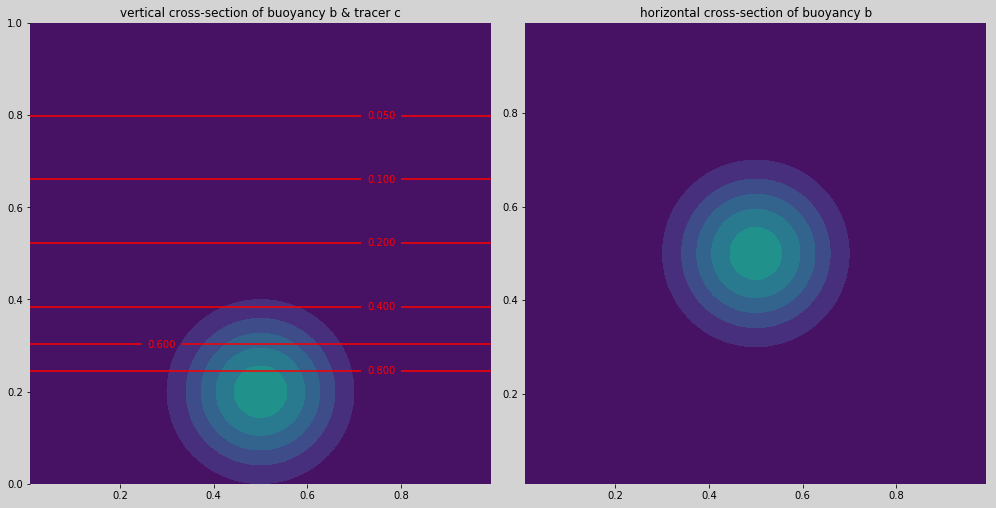

In [16]:
#quick,simple=plt.subplots(figsize=(12,6))
myfig = plt.figure(figsize=(16,8),facecolor='lightgrey')
ax1 = myfig.add_axes([0.08, 0.1, 0.4, .8*zmax/xmax],frameon=False) #vertical cross-section
ax2 = myfig.add_axes([0.51, 0.1, 0.4, .8*zmax/xmax],frameon=False) #horizontal cross-section
jp = Ny//2
kp = (Nz-1)//5
#jp=kp
ax1.contourf( xb[:,jp,:], zb[:,jp,:], bi[:,jp,:], np.linspace(-.05,1.05,12))
cs = ax1.contour( xb[:,jp,:], zb[:,jp,:], c[:,jp,:],levels=[0.01,0.05,0.1,0.2,0.4,0.6,0.8,1],colors=['r',])
ax1.clabel(cs,cs.levels)
ax1.set_title('vertical cross-section of buoyancy b & tracer c');
ax2.contourf( xb[kp,:,:], yb[kp,:,:], bi[kp,:,:], np.linspace(-.05,1.05,12))
ax2.set_title('horizontal cross-section of buoyancy b')

In [17]:
print("periodic=",periodic)    

dudt=0.*ui
dvdt=0.*vi
dwdt=0.*wi + bi

divaccel = div_Cgrid(dudt,dvdt,dwdt,dx,dy,dz)

print("prior, max divaccel",divaccel.max(),"min divaccel",divaccel.min())

inv_lapl_op = poisson3d_p_fft_prep(divaccel.shape,dx,dy,dz,periodic=periodic)
pi = poisson3d_p_fft(divaccel,inv_lapl_op,periodic=periodic)

pi = pi-pi.mean() # note PGF is independent of mean, but this prevents p.mean() from drifting

dudt[:,:,1:-1] += (pi[:,:,:-1]-pi[:,:,1:])/dx
dvdt[:,1:-1,:] += (pi[:,:-1,:]-pi[:,1:,:])/dy
dwdt[1:-1,:,:] += (pi[:-1,:,:]-pi[1:,:,:])/dz
if periodic:
    dudt[:,:,0] += ( pi[:,:,-1] - pi[:,:,0] )/dx
    dvdt[:,0,:] += ( pi[:,-1,:] - pi[:,0,:] )/dy
    dudt[:,:,-1] = dudt[:,:,0] 
    dvdt[:,-1,:] = dvdt[:,0,:]     
divaccel= div_Cgrid(dudt,dvdt,dwdt,dx,dy,dz)

print("after, max divaccel",divaccel.max(),"min divaccel",divaccel.min())

periodic= False
prior, max divaccel 3.2013438553519027 min divaccel -3.2017844298600515
after, max divaccel -0.0011056455884288496 min divaccel -0.0011056455887414884


In [18]:
#print(pi.max(),pi.min())
#quick,simple=plt.subplots(figsize=(13,10))
#ax = simple.pcolor(pi[:,jp,:]) # pcolor is simple, and shows the pixels
#simple.set_title("vertical cross-section of initial pressure P");
#plt.colorbar(ax)

<hr/>
# Set up the animation plot

In [19]:
if outdir != None and not os.path.exists(outdir): os.mkdir(outdir)
myfig = plt.figure(figsize=(16,8),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.4, .8*zmax/xmax],frameon=False) # vertical cross-section
ax3 = myfig.add_axes([0.02, 0.3333, 0.05333, .5333]) # for colorbar
ax4 = myfig.add_axes([0.5, 0.1, 0.4, .8*zmax/xmax],frameon=False) # horizontal cross-section
ax3.axis('off')
ax2.axis('off')
ax4.axis('off')
#ax1 = myfig.add_axes([0.1, 0.0500, 0.5333, .2666]) # line plot axes
#plt.setp( ax2.get_xticklabels(), visible=False);
cbar_exists=False
plt.close()

In [20]:
def doplot(jp=None,kp=None,iwant='xz'):
    global cbar_exists
    ax2.clear()
     
# VERTICAL CROSS SECTION
    if iwant=='xz':        
        if jp is None: jp=Ny//2  
        CF = ax2.contourf(xb[:,jp,:],zb[:,jp,:],b[:,jp,:],np.linspace(-.05,1.05,12),zorder=1,cmap='jet')
        ax2.contour(xp[:,jp,:],zp[:,jp,:],p[:,jp,:],.1*np.linspace(-2.05,2.05,42),colors=['w',],zorder=2)


        vd=1
        speedmax=.5  # anticipate value of max  
        u_at_p = (u[:,jp,:-1]+u[:,jp,1:])*.5
        w_at_p = (w[:-1,jp,:]+w[1:,jp,:])*.5
        Q = ax2.quiver(xp[::vd,jp,::vd],zp[::vd,jp,::vd],u_at_p[::vd,::vd],w_at_p[::vd,::vd],
            scale=speedmax*Nx/vd,units='width',zorder=3)
        cs = ax2.contour(yb[:,jp,:],zb[:,jp,:],c[:,jp,:],[0.01,0.03,0.05,0.1,0.2,0.4,0.6,0.8],colors=['magenta',],zorder=3) # tracer contour
        ax2.clabel(cs,cs.levels)
        ax2.annotate('rmax: ' + str(rbmax),xy=(0.75,0.9), color='w',fontsize=12)
        ax2.annotate('bmax: ' + str(np.round(bmax,decimals=4)),xy=(0.75,0.85), color='w',fontsize=12)
        ax2.annotate(expname,xy=(0.72,0.95), color='w',fontsize=14,fontweight='bold')
        
    elif iwant=='yz':
        
        if jp is None: jp=Nx//2   

        CF = ax2.contourf(yb[:,:,jp],zb[:,:,jp],b[:,:,jp],np.linspace(-.05,1.05,12),zorder=1,cmap='jet')
        ax2.contour(yp[:,:,jp],zp[:,:,jp],p[:,:,jp],.1*np.linspace(-2.05,2.05,42),colors=['w',],zorder=2)

        vd=1
        speedmax=.5  # anticipate value of max  
        v_at_p = (v[:,:-1,jp]+v[:,1:,jp])*.5
        w_at_p = (w[:-1,:,jp]+w[1:,:,jp])*.5
        Q = ax2.quiver(yp[::vd,::vd,jp],zp[::vd,::vd,jp],v_at_p[::vd,::vd],w_at_p[::vd,::vd],
            scale=speedmax*Nx/vd,units='width',zorder=3)
        cs = ax2.contour(yb[:,:,jp],zb[:,:,jp],c[:,:,jp],[0.01,0.03,0.05,0.1,0.2,0.4,0.6,0.8],colors=['magenta',],zorder=3) # tracer contour
        ax2.clabel(cs,cs.levels)
        ax2.annotate('rmax: ' + str(rbmax),xy=(0.75,0.9), color='w',fontsize=12)
        ax2.annotate('bmax: ' + str(np.round(bmax,decimals=4)),xy=(0.75,0.85), color='w',fontsize=12)
        ax2.annotate(expname,xy=(0.72,0.95), color='w',fontsize=14,fontweight='bold')

    speedf= "%7.3f"  % speedmax
    ax2.quiverkey(Q,.4*xmax,-.04*zmax,speedmax, speedf,zorder=4)
    
    ax2.text(.0,-.04*zmax,'t={0:5.2f}'.format(t),fontsize=22)
    peristring=""
    if periodic: peristring="periodic"
    expt = "%d,%d,%d   f=%4.1f   %s" % (Nx,Ny,Nz,fcoriolis,peristring)
    ax2.text(.7*xmax,-.04*zmax, expt,fontsize=18)
        
# HORIZONTAL CROSS-SECTION 
    if kp is None: kp=Nz//2
        
    ax4.clear()     
    ax4.contourf(xb[kp,:,:],yb[kp,:,:],b[kp,:,:],np.linspace(-.05,1.05,12),zorder=1,cmap='jet')
        
    vd=2 # swap from 2 to 1 - weiming
    speedmax=.1 # anticipate value of max    
    u_at_p = (u[kp,:,:-1]+u[kp,:,1:])*.5
    v_at_p = (v[kp,:-1,:]+v[kp,1:,:])*.5
    Q2 = ax4.quiver(xp[kp,::vd,::vd],yp[kp,::vd,::vd],u_at_p[::vd,::vd],v_at_p[::vd,::vd],
        scale=speedmax*Nx/vd,units='width',zorder=3,color='white')
    
    #-------- adding vertical vorticity contours -----------
    zdim, ydim, xdim = np.shape(p)
    a1 = np.zeros((zdim,ydim+1,xdim+1)); a2 = a1.copy()
    a1[kp,:,1:-1] = (v[kp,:,1:]-v[kp,:,:-1])/dx; a2[kp,1:-1,:]= -(u[kp,1:,:]-u[kp,:-1,:])/dy 
    eph = a1 + a2 # vertical vorticity
    ax4.contour(xp[kp,:,:],yp[kp,:,:],eph[kp,:-1,:-1],[0.25,0.5,1,3,5,7,9,11,13,15],colors=['lime',],zorder=2)
    ax4.annotate('Max $\zeta$: ' + str(np.round(eph[kp,:-1,:-11].max(),decimals=3)), xy=(0.7,0.9),
                 fontsize=16, fontweight='bold', color='lime')
    #-------------------------------------------------------
        
    speedf= "%7.3f"  % speedmax
    ax4.quiverkey(Q2,.4*xmax,-.04*ymax,speedmax, speedf,zorder=4)
    
    if not cbar_exists: #bad things happen if cbar is called more than once 
        cbar_exists = True
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.3)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
            
    ax2.axis('off')
    stop_clipping(ax2)
    ax4.axis('off')
    stop_clipping(ax4)

    clear_output(wait=True)

    display(myfig)   
    
    if outdir != None: 
        timestamp = round(t,2)
        pngname = outdir+'/%06d.png' % round(100*timestamp) 
        myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')

<hr/>
<a name="Energy_stats_arrays"></a>

# Ready to run at t=0

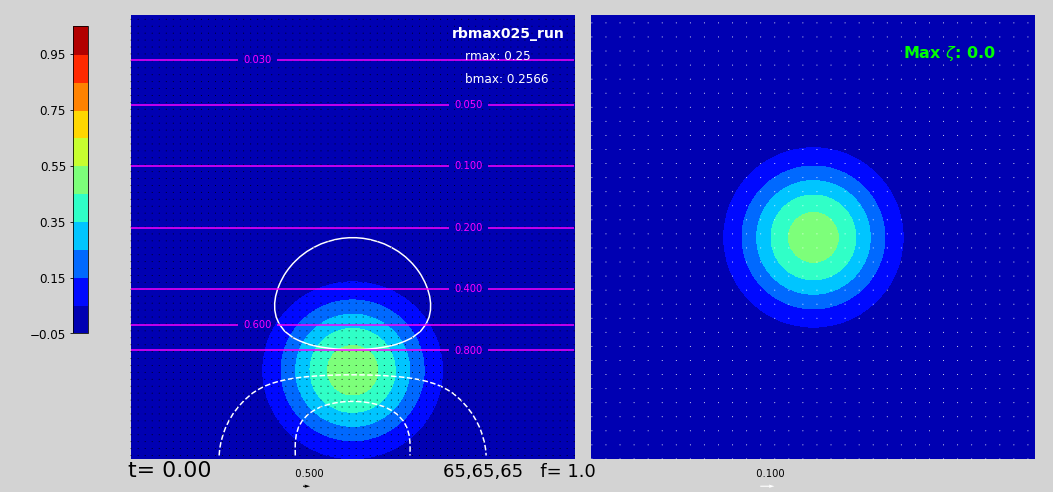

In [21]:
b=bi.copy()
u=ui.copy()
v=vi.copy()
w=wi.copy()
p=pi.copy() # not needed?

dbdta=[None]*3
dudta=[None]*3
dvdta=[None]*3
dwdta=[None]*3
dcdta=[None]*3

te=[] # for time series of total energy in the domain
ke=[] # for time series of total kinetic energy in the domain
pe=[] # for time series or total potential energy in the domain

#------ addtional outputs -------
vor=[] # for time series of vertical relative vorticity
ps_min=[] # for time series of P minimum at the surface
v_max = [] # for time series of maximum wind speed, sqrt(u^2+v^2)
b_vint = [] # for time series of vertically-intergrated buoyancy
w_max = [] # for time series of vertical velocity, w
ps_theo = [] # for time series of theoretical p', see task 2
ps_theoco = [] # for time series of theoretical p' related to coriolis, see task 2 
#---------------------------------

monitor = [] # for recording a diagnostic quantity at every time step
times = [] # time of the diagnostic
t = 0 #initial time
tstart = 0 # for time series plot
nstep = 0
tplot = 0 # next time to plot
dplot = .1 # interval between plots
dt = 0.5*dz/1.
doplot(kp=kp,iwant='yz')

<hr/>
<a name="Stepforward"></a>

# Step forward in time

You can repeatedly increase `tstop` and rerun the following cell.

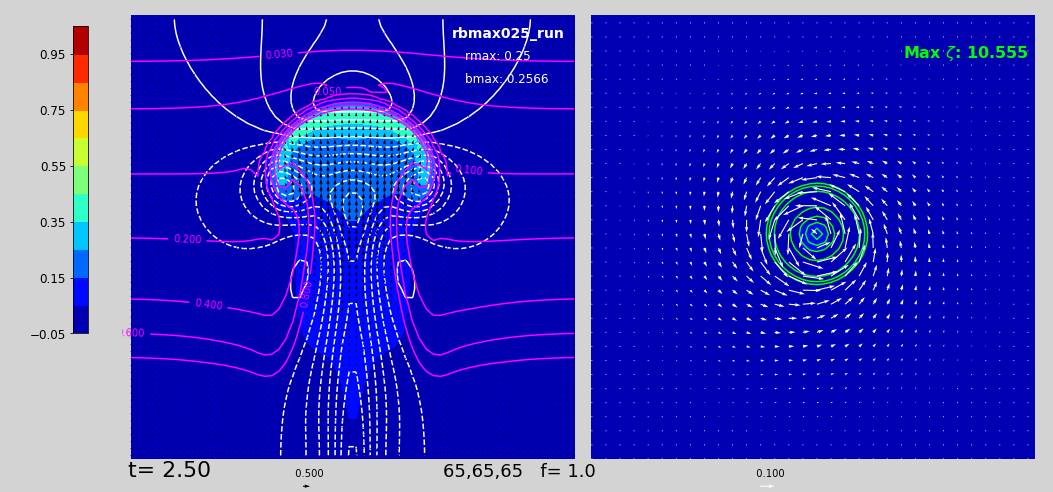

In [22]:
tstop = 2.5 #2.5

csav=[]

while t < tstop + dt/2.:
    
    bnd = 'slip'
    uw = u_to_w(u,bnd)
    vw = v_to_w(v,bnd)
    if periodic: bnd='per'
    vu = v_to_u(v,bnd)
    wu = w_to_u(w,bnd)
    uv = u_to_v(u,bnd)
    wv = w_to_v(w,bnd)
    
    if periodic:
        dudt =  advect_3dp(u,u,vu,wu,dx,dy,dz,'u')
        dvdt =  advect_3dp(v,uv,v,wv,dx,dy,dz,'v')
        dbdt =  advect_3dp(b,uw,vw,w,dx,dy,dz,'w')
        dwdt =  advect_3dp(w,uw,vw,w,dx,dy,dz,'w')
        dcdt =  advect_3dp(c,uw,vw,w,dx,dy,dz,'w') # tracer 
    else:
        dudt =  advect_3d(u,u,vu,wu,dx,dy,dz)
        dvdt =  advect_3d(v,uv,v,wv,dx,dy,dz)
        dbdt =  advect_3d(b,uw,vw,w,dx,dy,dz)
        dwdt =  advect_3d(w,uw,vw,w,dx,dy,dz)    
        dcdt =  advect_3d(c,uw,vw,w,dx,dy,dz) # tracer
        
    if fcoriolis!=0.: dudt +=  fcoriolis*vu #Coriolis term 
    if fcoriolis!=0.: dvdt += -fcoriolis*uv #Coriolis term
    dwdt += b


# Ensure no normal component of velocity develops on the boundaries:
    if not periodic:
        dudt[:,:,0]=0.
        dudt[:,:,-1]=0.
        dvdt[:,0,:]=0.
        dvdt[:,-1,:]=0.
    dwdt[0,:,:]=0.
    dwdt[-1,:,:]=0.
    

    divaccel= div_Cgrid(dudt,dvdt,dwdt,dx,dy,dz)
    divvel = div_Cgrid(u,v,w,dx,dy,dz)

    p = poisson3d_p_fft(divaccel + .4*divvel/dt, inv_lapl_op, periodic=periodic)

    p = p - p.mean() 
    
    dudt[:,:,1:-1] += ( p[:,:,:-1] - p[:,:,1:] )/dx
    dvdt[:,1:-1,:] += ( p[:,:-1,:] - p[:,1:,:] )/dy
    dwdt[1:-1,:,:] += ( p[:-1,:,:] - p[1:,:,:] )/dz

    if periodic:
        dudt[:,:,0] += ( p[:,:,-1] - p[:,:,0] )/dx
        dvdt[:,0,:] += ( p[:,-1,:] - p[:,0,:] )/dy

        
    if periodic:
        dudt[:,:,-1] = dudt[:,:,0] 
        dvdt[:,-1,:] = dvdt[:,0,:]         

    dudta=[dudt.copy()]+dudta[:-1]
    dvdta=[dvdt.copy()]+dvdta[:-1]
    dwdta=[dwdt.copy()]+dwdta[:-1]
    dbdta=[dbdt.copy()]+dbdta[:-1]
    dcdta=[dcdt.copy()]+dcdta[:-1] # tracer
    
#   step forward in time:
    nstep += 1
    abnow = min(nstep,aborder)
    b += dt*ab_blend(dbdta,abnow) 
    c += dt*ab_blend(dcdta,abnow)
    u += dt*ab_blend(dudta,abnow) 
    v += dt*ab_blend(dvdta,abnow) 
    w += dt*ab_blend(dwdta,abnow) 
    t += dt
    

    U=u_to_p(u)
    V=v_to_p(v)
    W=w_to_p(w)
    B=w_to_p(b)
          
    speed = np.sqrt(U*U + V*V + W*W)       
    kinEn = (.5*speed**2).mean()
#    potEn = (.5*B**2).mean()
    potEn = -(B*zp).mean()
    ke.append(kinEn)
    pe.append(potEn)
    te.append(kinEn+potEn)
    times.append(t)
    csav.append(np.sum(c.ravel())/ctot)
    
    #------ relationship between P'center and integrals of Vtan^2/r + f*Vtan in the radial direction ----
    dcen = np.zeros(len(xp[0,Ny//2,Nx//2:]))
    dco = dcen.copy()
    
    for r in range(Nx//2):
        if r is not 0: # avoid divided by 0
            dcen[r] = V[0,Ny//2,r]**2/(xp[0,Ny//2,r]-xp[0,Ny//2,Nx//2]) # centrifugal term
        dco[r] = fcoriolis*V[0,Ny//2,r] # coriolis term
    
    p_theo_cen = np.trapz(dcen,dx=dx) # theoretical p' related with the centrifugal force
    p_theo_co = np.trapz(dco,dx=dx) # theoretical p' related with coriolis
    p_theo_all = (p_theo_cen + p_theo_co) # theoretical p' at the surface
    #------------------------------------------
    
    
    #----- additional output by weiming -------
    w_speed = np.sqrt(U*U+V*V) # horizontal wind speed
    
    zdim, ydim, xdim = np.shape(p)
    a1 = np.zeros((zdim,ydim+1,xdim+1)); a2 = a1.copy()
    a1[:,:,1:-1] = (v[:,:,1:]-v[:,:,:-1])/dx; a2[:,1:-1,:]= -(u[:,1:,:]-u[:,:-1,:])/dy 
    eph = a1 + a2 # vertical vorticity
    
    bint = np.trapz(b,dx=dz,axis=0) # vertically-integrated buoyancy
    
    v_max.append(w_speed.max())
    vor.append((eph[0,:,:]).max())
    ps_min.append(p[0,Nx//2,Ny//2])
    b_vint.append(bint.max())
    w_max.append(W.max())
    ps_theo.append(p_theo_all)
    ps_theoco.append(p_theo_co)
    #-------------------------------------------
    
    
    
    if  tplot-dt/2. < t: 
        doplot(kp=kp,iwant='yz')
        tplot = tplot + dplot
plt.close()

In [23]:
divvel=div_Cgrid(u,v,w,dx,dy,dz)
print("should be small:",divvel.max(),divvel.min())

should be small: 1.3766765505351941e-14 -1.687538997430238e-14


In [24]:
# save variables to txt file for further comparison
var_sav = np.zeros((4,len(ps_min)))
var_sav[0,:] = np.asarray(ps_min) #  central p' at the surface
var_sav[1,:] = np.asarray(vor) # max vertical vorticity at the surface
var_sav[2,:] = np.asarray(v_max) # max horizontal wind 
var_sav[3,:] = np.asarray(w_max) # max vertical velocity

np.savetxt(expname + '_evolution.txt', var_sav) 

<a name="Animation_and_stats"></a>
## Build the animation and plot the statistics
### somebody improve animation please from [Wei-Ming's example!](https://github.com/ATMOcanes/ATM663_convection_meso/network/members)


In [25]:
import imageio

path = "/Users/willytsai/ATM663_convection_meso/Assignments/Notebooks/"+outdir
os.chdir(path)
filenames = sorted(glob.glob('*.png'))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./tornedo3d_ctrl.gif', images) # convert plots into a gif movie

<a name="Student_tasks"></a>

# Student Tasks

## 1. Make more stats monitoring outputs

Write a function to calculate vertical vorticity $\zeta$. 

Improve the monitoring section to show time series of volume-integrated $b$, maximum $v$, maximum $\zeta$, minimum $p$ at the surface, skew of w, 3D covariance [bw], or other useful statistics in addition to the energies already there. Test these monitoring tools with the control_run case. 

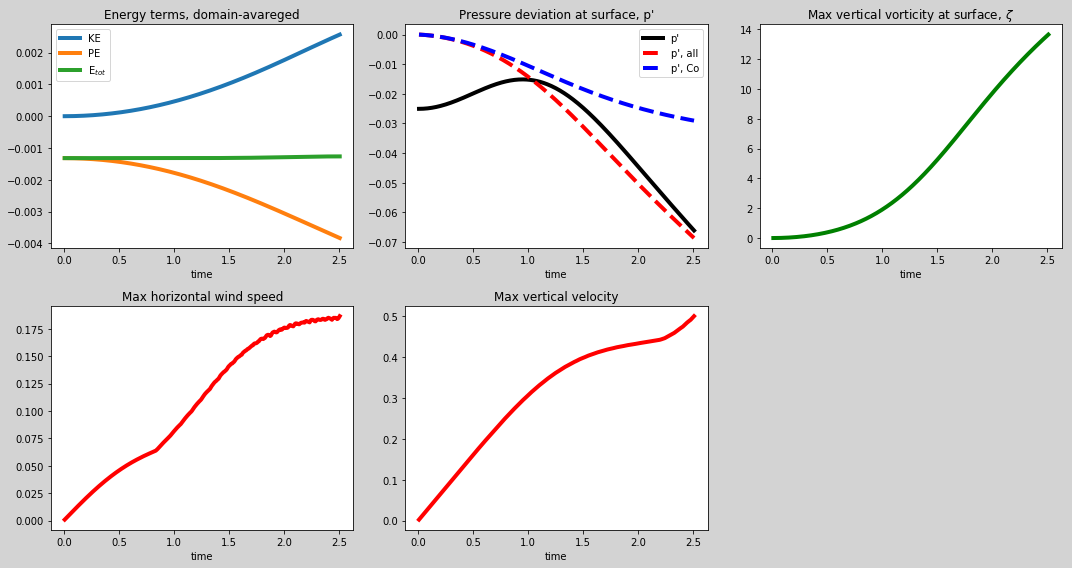

In [26]:
fig = plt.figure(figsize=(15,8),facecolor='lightgrey')
ax1 = plt.subplot(2,3,1)
ax1.plot(times,ke,linewidth=4)
ax1.plot(times,pe,linewidth=4)
ax1.plot(times,te,linewidth=4)
ax1.set_title('Energy terms, domain-avareged')
ax1.legend(['KE','PE','E$_{tot}$'])
ax1.set_xlabel('time')

ax2 = plt.subplot(2,3,2)
ax2.plot(times,ps_min,'k',linewidth=4)
ax2.plot(times,ps_theo,'--r',linewidth=4)
ax2.plot(times,ps_theoco,'--b',linewidth=4)
ax2.legend(["p'","p', all","p', Co"])
ax2.set_title("Pressure deviation at surface, p'")
ax2.set_xlabel('time')

ax3 = plt.subplot(2,3,3)
ax3.plot(times,vor,'g',linewidth=4)
ax3.set_title('Max vertical vorticity at surface, ${\zeta}$')
ax3.set_xlabel('time')

ax4 = plt.subplot(2,3,4)
ax4.plot(times,v_max,'r',linewidth=4)
ax4.set_title('Max horizontal wind speed')
ax4.set_xlabel('time')

ax5 = plt.subplot(2,3,5)
ax5.plot(times,w_max,'r',linewidth=4)
ax5.set_title('Max vertical velocity')
ax5.set_xlabel('time')

plt.tight_layout()

## 2. Tracer displacement and vortex stretching 

Add a field $c(x,y,z,t)$ that has no effect on the dynamics.  You need to simply follow what is done for $b$, except $c$ does not appear in any momentum equation. Initialize $c(x,y,z,0)=z$ or $c(x,y,z,0)=r$, a tracer of initial parcel position. Add contours of $c$ in `doplot`, in the vertical cross-section.

From the deformation of $c$, you should be able to discern the amount of vortex stretching that occurs in the "tornado". 

Plot contours of relative vorticity $\zeta$ in the horizontal cross section of `doplot`.

Perform some calculations that check to see if the increase of $\zeta$ in the horizontal cross section is consistent with the stretching you deduced from the contours of $c$ in the vertical cross section.

<img src='./control_run/tornedo3d_ctrl.gif?20'>

## 3. Relate single point stats (Vmax, central pressure) to flow integrals and initial conditions

Can you to validate this relationship between an integral and a point value, the pressure depression in the center of the vortex?

$$
p'_{central} = -\int_{r=large}^{r=0} {(v_{tan}^2/r + fv_{tan}) dr}
$$

How important is the Coriolis force in your cases? That is, how much of the answer could you get from 

$$
p'_{central} = -\int_{r=large}^{r=0} {(v_{tan}^2/r) dr}
$$

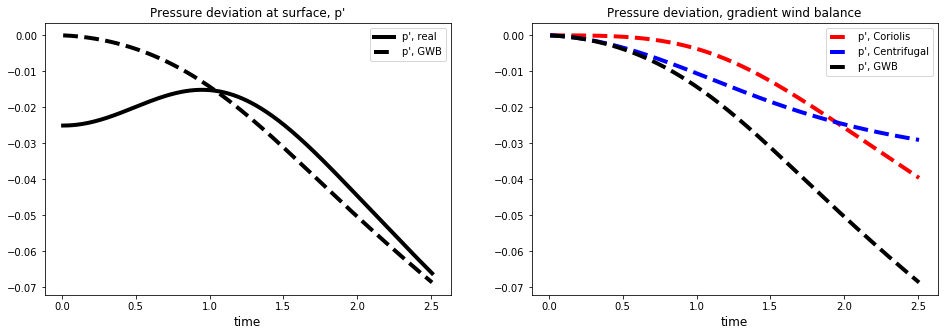

In [27]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(times,ps_min,'k',linewidth=4)
ax1.plot(times,ps_theo,'--k',linewidth=4)
ax1.legend(["p', real","p', GWB",])
ax1.set_title("Pressure deviation at surface, p'")
ax1.set_xlabel('time',fontsize=12)

ax2 = plt.subplot(1,2,2)
ax2.plot(times,np.asarray(ps_theo)-np.asarray(ps_theoco),'--r',linewidth=4)
ax2.plot(times,ps_theoco,'--b',linewidth=4)
ax2.plot(times,ps_theo,'--k',linewidth=4)
ax2.set_xlabel('time',fontsize=12)
ax2.set_title('Pressure deviation, gradient wind balance')
ax2.legend(["p', Coriolis","p', Centrifugal","p', GWB"])

## 4. Parameter sweep!

To build confidence, go to the <a href="#Initialize">double red bar</a> and adjust `fcoriolis`, as one simple experiment. Here are reference results for `fcoriolis` = 0,1,2,3:

<img src="./control_run/tornedo3d_ctrl.gif?20">
<img src="./rbmax017_run/tornedo3d_ctrl.gif?1">
<img src="./rbmax025_run/tornedo3d_ctrl.gif?1">

### Summary of sensitivity tests 


control_run
rbmax017_run
rbmax019_run
rbmax022_run
rbmax025_run


Text(0.5, 1.0, 'maximum vertical velocity')

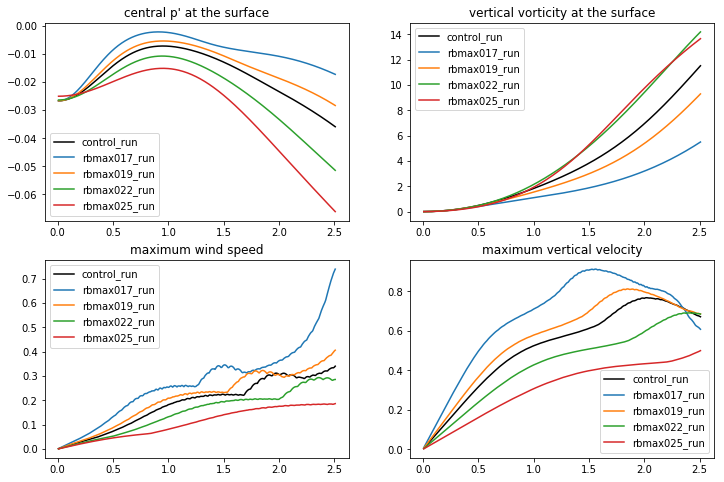

In [36]:
exp_list = ['control_run','rbmax017_run','rbmax019_run','rbmax022_run','rbmax025_run']
ps_sum = np.zeros((len(exp_list),len(ps_min))); vormax_sum = ps_sum.copy()
vmax_sum = ps_sum.copy(); wmax_sum = ps_sum.copy()

for idx, fid in enumerate(exp_list):
    print(fid)
    os.chdir('/Users/willytsai/ATM663_convection_meso/Assignments/Notebooks/'+fid)
    data = np.loadtxt(fid+'_evolution.txt')
    ps_sum[idx,:] = data[0,:] 
    vormax_sum[idx,:] = data[1,:]
    vmax_sum[idx,:] = data[2,:]
    wmax_sum[idx,:] = data[3,:]

# plotting 
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax1.plot(times,ps_sum[0,:],'k',times,ps_sum[1,:],times,ps_sum[2,:],times,ps_sum[3,:],times,ps_sum[4,:])
ax1.legend(exp_list)
ax1.set_title("central p' at the surface")

ax1 = plt.subplot(2,2,2)
ax1.plot(times,vormax_sum[0,:],'k',times,vormax_sum[1,:],times,vormax_sum[2,:],times,vormax_sum[3,:],times,vormax_sum[4,:])
ax1.legend(exp_list)
ax1.set_title("vertical vorticity at the surface")

ax1 = plt.subplot(2,2,3)
ax1.plot(times,vmax_sum[0,:],'k',times,vmax_sum[1,:],times,vmax_sum[2,:],times,vmax_sum[3,:],times,vmax_sum[4,:])
ax1.legend(exp_list)
ax1.set_title("maximum wind speed")

ax1 = plt.subplot(2,2,4)
ax1.plot(times,wmax_sum[0,:],'k',times,wmax_sum[1,:],times,wmax_sum[2,:],times,wmax_sum[3,:],times,wmax_sum[4,:])
ax1.legend(exp_list)
ax1.set_title("maximum vertical velocity")


## Your own parameter  

The strength of the surface rotation (by various different measures) has various dependencies on f, and on the warm bubble. 

Horizontal displacement is what makes tangential wind, so width may matter. But we know bubbles penetrate better when they are tall and narrow, because BPGF opposes b less effectively, so maybe a tall bubble has a greater "thermodynamic speed limit" (ask Dr. Nolan!) And of course f matters, but for really large f the bubble can't even rise very far before geostrophic balance develops and holds it in place. 

**With 3 students, let's explore 3 parameters, over 5 values:**

1. Wei-Ming: Width of the bubble (keeping volume-integrated b constant by adjusting bmax). 
1. Haozhe: Height of the bubble (keeping volume-integrated b constant by adjusting bmax).
1. Ryder: Coriolis force: try really large values where geostrophic balance soon keeps it from rising.

**Make 5 experiments, based around the control run (like two doublings/halvings).**

**Be prepared to explain your results in a class discussion on Thursday with Dr. Nolan.**